In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender==1.0.8 
!pip install box2d-py
import gym
from colabgymrender.recorder import Recorder

env = gym.make("LunarLander-v2")
directory = './video'
env = Recorder(env, directory)

observation = env.reset()
terminal = False
while not terminal:
  action = env.action_space.sample()
  observation, reward, terminal, info = env.step(action)

env.play()

In [2]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

# Model




In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model that maps state -> action values.."""

    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [24]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [32]:
TAU = 1e-3             
LR = 5e-4               
UPDATE_EVERY = 4   
BATCH_SIZE = 64         
GAMMA = 0.99  
BUFFER_SIZE = int(1e5)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Agent

In [25]:
class Agent():

    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy 
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    def step(self, state, action, reward, next_state, done):
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        self.memory.add(state, action, reward, next_state, done)

        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    

    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, dones = experiences

        
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
       
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# Training

In [26]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    eps = eps_start
    scores = []                        
    scores_window = deque(maxlen=100)  
                       
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps) 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nPassed in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -191.34
Episode 200	Average Score: -124.09
Episode 300	Average Score: -39.55
Episode 400	Average Score: 36.20
Episode 500	Average Score: 152.86
Episode 600	Average Score: 159.02
Episode 700	Average Score: 200.16

Environment solved in 600 episodes!	Average Score: 200.16


Text(0, 0.5, 'Score')

Text(0.5, 0, 'Episode #')

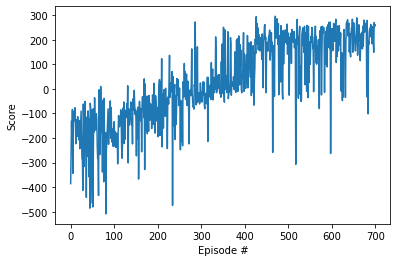

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.play()

100%|█████████▉| 345/346 [00:02<00:00, 129.96it/s]


# Version 2 - Implement the PPO algorithm in actor-critic style

In [4]:
train_env = gym.make('LunarLander-v2')
test_env = gym.make('LunarLander-v2')
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);


In [ ]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

###
actor =  QNetwork(8, 4, seed=0).to(device)
#critic = Critic(INPUT_DIM, HIDDEN_DIM, 1)
#policy = ActorCritic(actor, critic)
###

dqn_model = QNetwork(8, 4, seed=0).to(device)
dqn_model.load_state_dict(torch.load("checkpoint.pth"))
dqn_model = dqn_model.to(device)

<All keys matched successfully>

In [ ]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(actor.parameters(), lr = LEARNING_RATE)

In [ ]:
def train(env, policy, optimizer, discount_factor, ppo_steps, ppo_clip, dqn_model):
        
    policy.train()
    states = []
    actions = []
    log_prob_actions = []
    #values = []
    rewards = []
    done = False
    episode_reward = 0
    action_advantages = []
    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        #append state here, not after we get the next state from env.step()
        states.append(state)

        #action_pred, value_pred = policy(state)

        action_pred = policy(state)

        action_advan = dqn_model(state)

        action_advan = F.softmax(action_advan, dim = -1)

        action_advan = (action_advan - action_advan.mean())
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        action_advantages.append(action_advan.cpu().data.numpy()[0][action.item()])#(np.argmax(action_advan.cpu().data.numpy()))
        
        state, reward, done, _ = env.step(action.item())
        #action = torch.tensor(float(action))
        
        actions.append(action)
        log_prob_actions.append(log_prob_action)
        #values.append(value_pred)
        rewards.append(reward)
        #advantages.append(advantage)
        episode_reward += reward
    #print(type(states))
    states = torch.cat(states)
    #print(type(states))
    #actions = tuple(actions)
    
    actions = torch.cat(actions) 
    #actions = torch.stack(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    #values = torch.cat(values).squeeze(-1)
    
    #advantages = actions - actions.mean()
    #print(advantages)
    #advantages = [t.cpu().detach().numpy() for t in action_advantages]
    advantages = torch.tensor(action_advantages)
    returns = calculate_returns(rewards, discount_factor)
    #advantages = calculate_advantages(returns, values)
    action_advantages = torch.from_numpy(np.stack(action_advantages)).to(device)
    #policy_loss, value_loss = update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip)
    policy_loss = update_policy(policy, states, actions, log_prob_actions, action_advantages, returns, optimizer, ppo_steps, ppo_clip, dqn_model)

    return policy_loss, episode_reward

In [ ]:
import torch.distributions as distributions
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

def update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip, dqn_model):
    
    total_policy_loss = 0 
    #total_value_loss = 0
    states = states.detach()
    actions = actions.detach()
    log_prob_actions = log_prob_actions.detach()
    advantages = advantages.detach()
    returns = returns.detach()
    
    for _ in range(ppo_steps):
        #get new log prob of actions for all input states
        #action_pred, value_pred = policy(states)
        action_pred = policy(states)
        #action_pred= dqn_model(states)
        #value_pred = value_pred.squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
        #print(policy_ratio)
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()
        
        #value_loss = F.smooth_l1_loss(returns, value_pred).mean()
    
        optimizer.zero_grad()

        policy_loss.backward()
        #value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        #total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps#, total_value_loss / ppo_steps
def evaluate(env, policy, dqn_model):
    
    policy.eval()
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        with torch.no_grad():
        
            #action_pred, _ = policy(state)
            action_pred = policy(state)
            #action_pred = dqn_model(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward


In [ ]:
MAX_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    #policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP, dqn_model)
    policy_loss, train_reward = train(train_env, actor, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP, dqn_model)
    
    test_reward = evaluate(test_env, actor, dqn_model)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
        
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')        
        break

| Episode:  10 | Mean Train Rewards:  -158.2 | Mean Test Rewards:  -468.7 |
| Episode:  20 | Mean Train Rewards:  -175.4 | Mean Test Rewards:  -655.4 |
| Episode:  30 | Mean Train Rewards:  -156.9 | Mean Test Rewards:  -637.0 |
| Episode:  40 | Mean Train Rewards:  -183.5 | Mean Test Rewards:  -462.4 |
| Episode:  50 | Mean Train Rewards:  -175.1 | Mean Test Rewards:  -344.0 |
| Episode:  60 | Mean Train Rewards:  -224.6 | Mean Test Rewards:  -332.4 |
| Episode:  70 | Mean Train Rewards:  -222.9 | Mean Test Rewards:  -295.4 |
| Episode:  80 | Mean Train Rewards:  -226.2 | Mean Test Rewards:  -172.8 |
| Episode:  90 | Mean Train Rewards:  -177.2 | Mean Test Rewards:   -96.4 |
| Episode: 100 | Mean Train Rewards:   -98.0 | Mean Test Rewards:   -93.3 |
| Episode: 110 | Mean Train Rewards:   -89.4 | Mean Test Rewards:  -107.6 |
| Episode: 120 | Mean Train Rewards:   -46.8 | Mean Test Rewards:  -116.2 |
| Episode: 130 | Mean Train Rewards:    11.9 | Mean Test Rewards:   -82.2 |
| Episode: 1

In [ ]:
torch.save(actor.state_dict(), 'bonus_checkpoint.pth')

In [8]:
actor = QNetwork(8, 4, seed=0).to(device)
actor.load_state_dict(torch.load("bonus_checkpoint.pth"))
actor = actor.to(device)

<All keys matched successfully>

In [14]:
from gym import wrappers
env = gym.make('LunarLander-v2')
env.seed(3)
env = wrappers.Monitor(env, "./gym-results", force=True)

action1 = []
action2 = []
action3 = []
action4 = []



state = env.reset()
for j in range(1000):
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    action_prob = actor(state)
    action_prob = F.softmax(action_prob, dim = -1)
    action1.append(action_prob[0][0])
    action2.append(action_prob[0][1])
    action3.append(action_prob[0][2])
    action4.append(action_prob[0][3])
    action = torch.argmax(action_prob, dim = -1)
    state, reward, done, _ = env.step(action.item())
    if done: break

env.close()

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

[3]

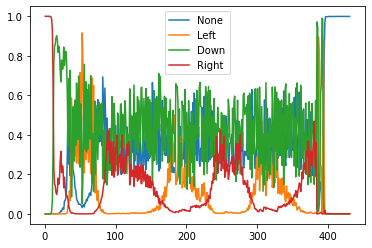

In [23]:
import matplotlib.pyplot as plt
import numpy as np
  
x = []
for i in range(len(action1)):
  x.append(i+1) 
action1 = torch.tensor(action1, device = 'cpu')
action2 = torch.tensor(action2, device = 'cpu')
action3 = torch.tensor(action3, device = 'cpu')
action4 = torch.tensor(action4, device = 'cpu')

plt.plot(x, action1, label = "None")
plt.plot(x, action2, label = "Left")
plt.plot(x, action3, label = "Down")
plt.plot(x, action4, label = "Right")
plt.legend()
plt.show()